In [3]:
import sys
sys.path.append("../../helper")
from AnalysisHelper import helper

from datetime import datetime as dt
from datetime import timedelta
from pandas import read_excel, to_datetime
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
import seaborn as sb


import requests
import json
from pandas import DataFrame, to_datetime
import sys
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas import DataFrame, MultiIndex, concat, DatetimeIndex
from matplotlib import pyplot as plt
sys.path.append("../../helper")
from statsmodels.tsa.seasonal import seasonal_decompose
import datetime as dict
from matplotlib import pyplot as pyplot
from matplotlib import dates as mdates
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from tabulate import tabulate

from statsmodels.tsa.arima.model import ARIMA

from pmdarima.arima import auto_arima
import seaborn as sb

#from helper import set_datetime_index, exp_time_data


# 시계열 분석 연습문제

## 문제 2

다음의 데이터는 `1981년 01월`부터 `2023년 05월`까지 전국에서 출생한 신생아 수를 조사하여 시,도별로 표시한 자료의 일부이다.

| 시점        | 서울특별시  | 부산광역시 | 대구광역시 | 인천광역시 |
|-----------|--------|-------|-------|-------|
| 1981년 01월 | 21,461 | 7,846 | 3,547 | 2,886 |
| 1981년 02월 | 23,389 | 8,622 | 3,588 | 3,044 |
| 1981년 03월 | 15,042 | 6,284 | 2,885 | 2,456 |
| 1981년 04월 | 15,231 | 5,806 | 2,783 | 2,369 |
| 1981년 05월 | 16,239 | 6,225 | 2,808 | 2,468 |

전체 자료는 아래의 URL을 통해 내려받을 수 있다.

```plain
https://data.hossam.kr/E06/newborn.xlsx
```

이 데이터를 활용하여 조사기간동안 태어난 신생아 수가 어떻게 변화하고 있는지 ARIMA와 AUTO_ARIMA중 자신이 사용 가능한 방식 하나를 선정하여 분석하고 앞으로 5년간의 신생아 수를 예측한 자료를 시각화 하시오.

단, 조사되지 않은 항목에 대해서는 신생아수가 `0`인 것으로 간주한다.

In [4]:
origin = read_excel("https://data.hossam.kr/E06/newborn.xlsx")
origin.head()

,시점,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
0,1981년 01월,21461,7846,3547,2886,NaN,NaN,NaN,NaN,9685,3729,3002,6293,4956,8741,7454,7501,1050
1,1981년 02월,23389,8622,3588,3044,NaN,NaN,NaN,NaN,10352,3637,3161,7761,5326,8319,7446,8039,872
2,1981년 03월,15042,6284,2885,2456,NaN,NaN,NaN,NaN,7727,3158,2486,5214,3855,7566,6229,6714,805
3,1981년 04월,15231,5806,2783,2369,NaN,NaN,NaN,NaN,7321,3166,2230,4621,3634,6553,5548,6079,752
4,1981년 05월,16239,6225,2808,2468,NaN,NaN,NaN,NaN,7823,3234,2419,4879,3709,6564,5529,6222,821


In [5]:
origin.dtypes

시점          object
서울특별시        int64
부산광역시        int64
대구광역시        int64
인천광역시        int64
광주광역시      float64
대전광역시      float64
울산광역시      float64
세종특별자치시    float64
경기도          int64
강원도          int64
충청북도         int64
충청남도         int64
전라북도         int64
전라남도         int64
경상북도         int64
경상남도         int64
제주특별자치도      int64
dtype: object

In [8]:
# 덧셈해서 맨 뒤에다가 뭐 놔야겠당
origin['시점'] = to_datetime(origin['시점'],format="%Y년 %m월")
origin.dtypes

시점         datetime64[ns]
서울특별시               int64
부산광역시               int64
대구광역시               int64
인천광역시               int64
광주광역시             float64
대전광역시             float64
울산광역시             float64
세종특별자치시           float64
경기도                 int64
강원도                 int64
충청북도                int64
충청남도                int64
전라북도                int64
전라남도                int64
경상북도                int64
경상남도                int64
제주특별자치도             int64
dtype: object

In [10]:
# 헬퍼 

def set_datetime_index(df, field=None, inplace=False):
    """
        데이터 프레임의 인덱스를 datetime 형식으로 변환

        Parameters
        -------
        - df: 데이터 프레임
        - inplace: 원본 데이터 프레임에 적용 여부

        Returns
        -------
        - 인덱스가 datetime 형식으로 변환된 데이터 프레임
    """
    
    if inplace:
        if field is not None:
            df.set_index(field, inplace=True)
            
        df.index = DatetimeIndex(df.index.values, freq=df.index.inferred_freq)
        df.sort_index(inplace=True)
    else:
        cdf = df.copy()
        
        if field is not None:
            cdf.set_index(field, inplace=True)
            
        cdf.index = DatetimeIndex(cdf.index.values, freq=cdf.index.inferred_freq)
        cdf.sort_index(inplace=True)
        return cdf

In [11]:
# 날짜 형식의 인덱스 설정
df = set_datetime_index(origin, '시점')
df.head()

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
1981-01-01,21461,7846,3547,2886,NaN,NaN,NaN,NaN,9685,3729,3002,6293,4956,8741,7454,7501,1050
1981-02-01,23389,8622,3588,3044,NaN,NaN,NaN,NaN,10352,3637,3161,7761,5326,8319,7446,8039,872
1981-03-01,15042,6284,2885,2456,NaN,NaN,NaN,NaN,7727,3158,2486,5214,3855,7566,6229,6714,805
1981-04-01,15231,5806,2783,2369,NaN,NaN,NaN,NaN,7321,3166,2230,4621,3634,6553,5548,6079,752
1981-05-01,16239,6225,2808,2468,NaN,NaN,NaN,NaN,7823,3234,2419,4879,3709,6564,5529,6222,821


In [15]:
df.isna().sum()

서울특별시        0
부산광역시        0
대구광역시        0
인천광역시        0
광주광역시       60
대전광역시       96
울산광역시      192
세종특별자치시    372
경기도          0
강원도          0
충청북도         0
충청남도         0
전라북도         0
전라남도         0
경상북도         0
경상남도         0
제주특별자치도      0
dtype: int64

In [19]:
# 결측치정제
df2 = df.fillna(0)
df2.head()


,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도
1981-01-01,21461,7846,3547,2886,0.0,0.0,0.0,0.0,9685,3729,3002,6293,4956,8741,7454,7501,1050
1981-02-01,23389,8622,3588,3044,0.0,0.0,0.0,0.0,10352,3637,3161,7761,5326,8319,7446,8039,872
1981-03-01,15042,6284,2885,2456,0.0,0.0,0.0,0.0,7727,3158,2486,5214,3855,7566,6229,6714,805
1981-04-01,15231,5806,2783,2369,0.0,0.0,0.0,0.0,7321,3166,2230,4621,3634,6553,5548,6079,752
1981-05-01,16239,6225,2808,2468,0.0,0.0,0.0,0.0,7823,3234,2419,4879,3709,6564,5529,6222,821


In [20]:
# 전국에 댇한 파생변수 생성
df2['전국'] = df2.sum(axis=1)
df2.head()

,서울특별시,부산광역시,대구광역시,인천광역시,광주광역시,대전광역시,울산광역시,세종특별자치시,경기도,강원도,충청북도,충청남도,전라북도,전라남도,경상북도,경상남도,제주특별자치도,전국
1981-01-01,21461,7846,3547,2886,0.0,0.0,0.0,0.0,9685,3729,3002,6293,4956,8741,7454,7501,1050,88151.0
1981-02-01,23389,8622,3588,3044,0.0,0.0,0.0,0.0,10352,3637,3161,7761,5326,8319,7446,8039,872,93556.0
1981-03-01,15042,6284,2885,2456,0.0,0.0,0.0,0.0,7727,3158,2486,5214,3855,7566,6229,6714,805,70421.0
1981-04-01,15231,5806,2783,2369,0.0,0.0,0.0,0.0,7321,3166,2230,4621,3634,6553,5548,6079,752,66093.0
1981-05-01,16239,6225,2808,2468,0.0,0.0,0.0,0.0,7823,3234,2419,4879,3709,6564,5529,6222,821,68940.0


결측치 수: 0


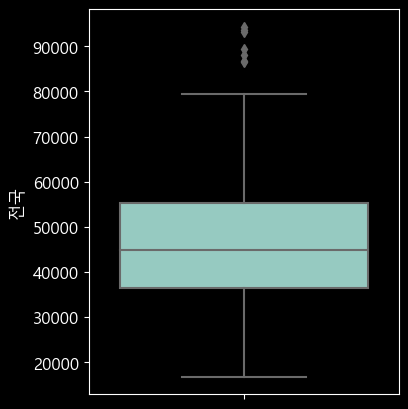

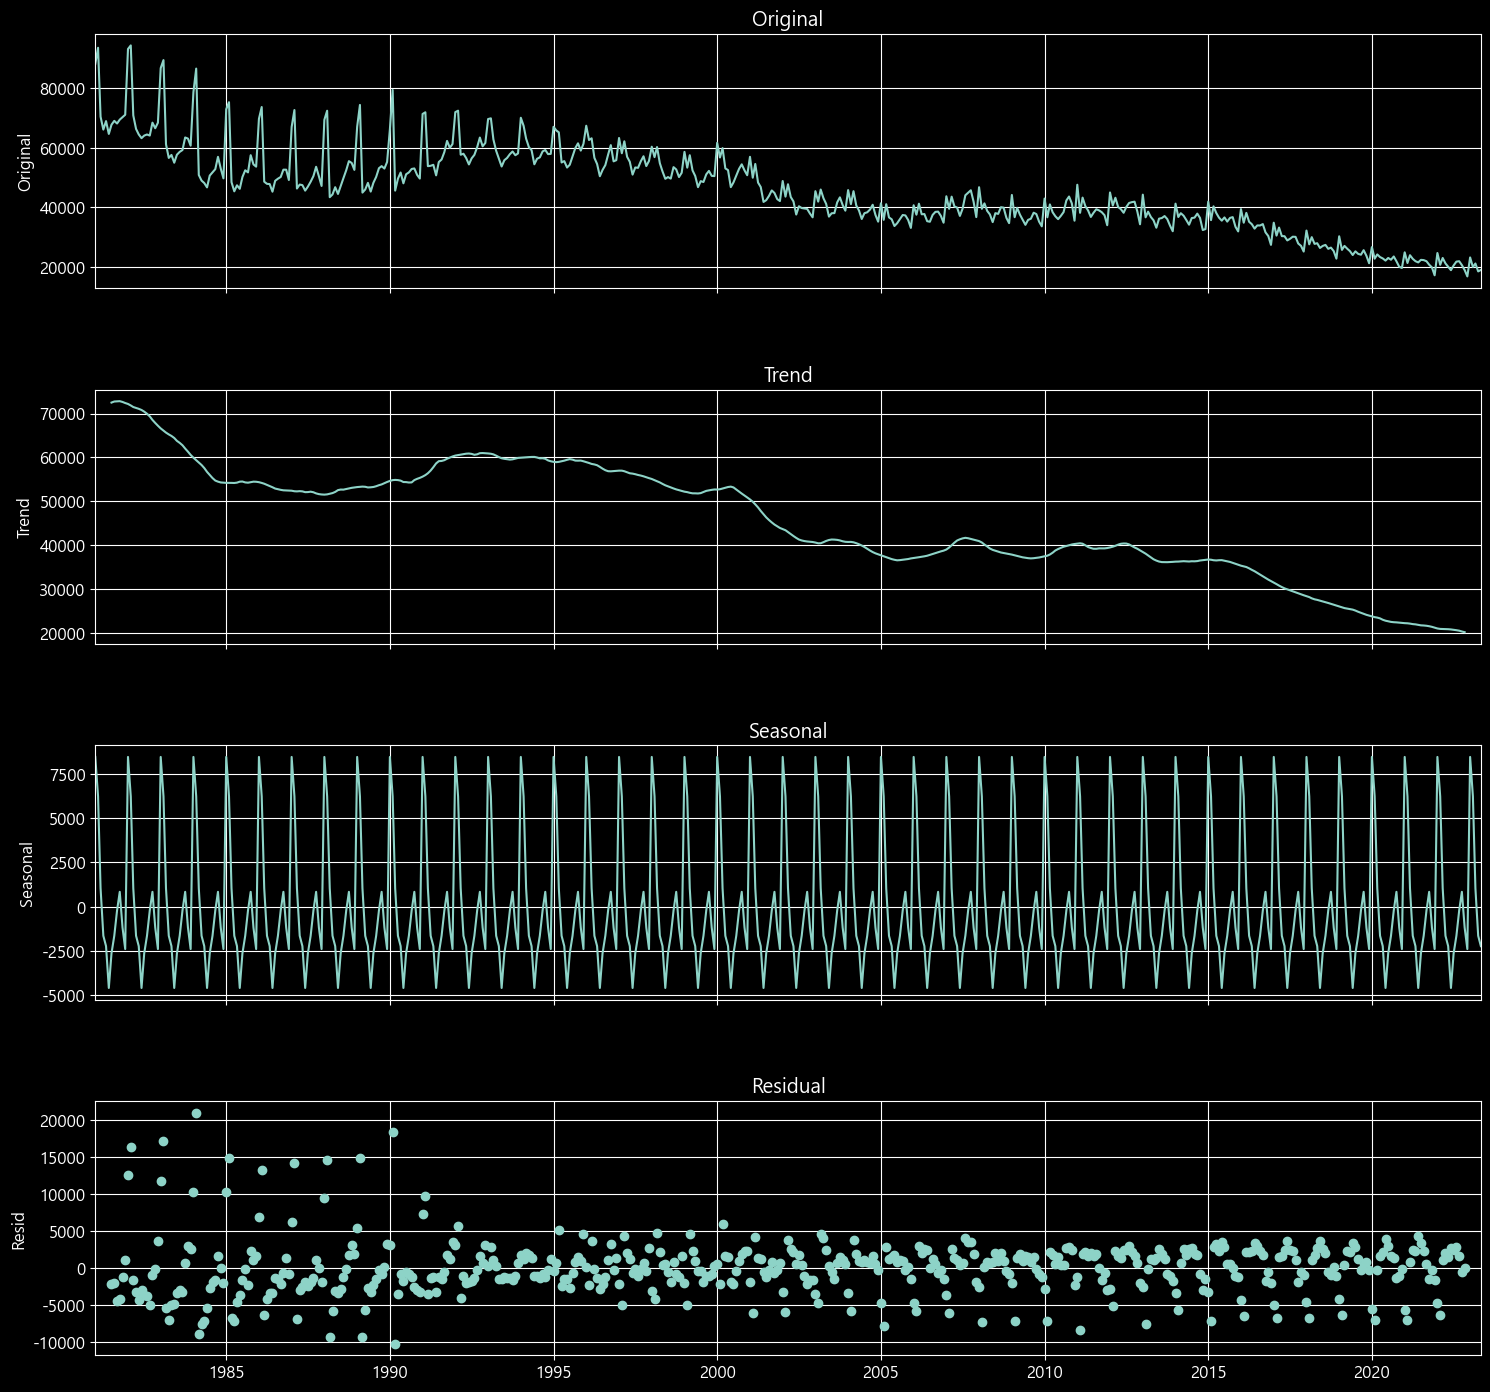

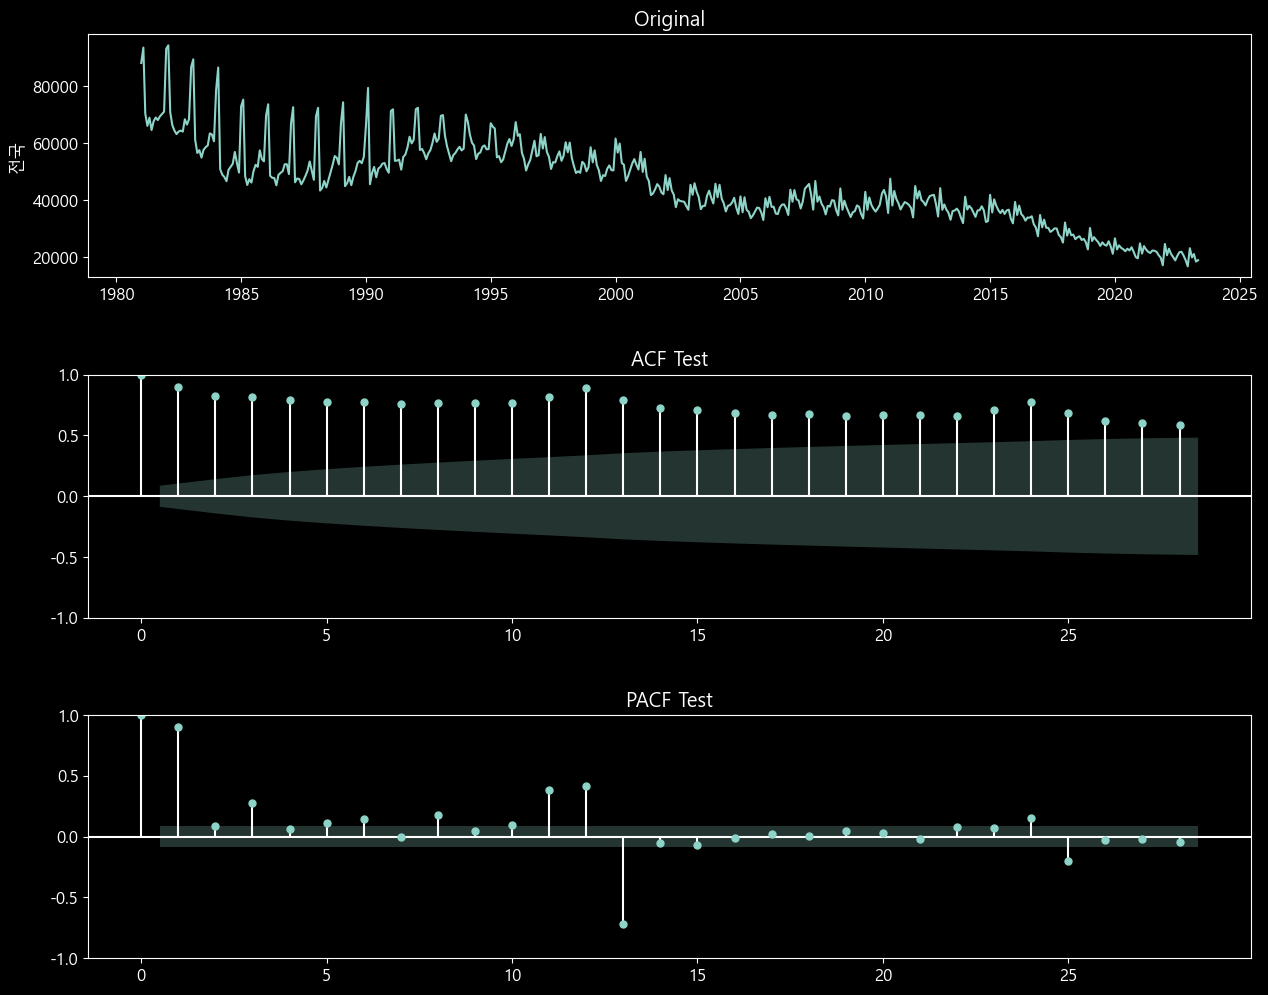

=========== 원본 데이터 ===========
+------------------------------------+----------+
| ADF Test                           |          |
|------------------------------------+----------|
| 검정통계량(ADF Statistic)          | -1.38402 |
| 유의수준(p-value)                  | 0.589914 |
| 최적차수(num of lags)              |       13 |
| 관측치 개수(num of observations)   |      495 |
| 기각값(Critical Values) 1%         | -3.44363 |
| 기각값(Critical Values) 5%         |  -2.8674 |
| 기각값(Critical Values) 10%        | -2.56989 |
| 데이터 정상성 여부(0=Flase,1=True) |        0 |
+------------------------------------+----------+


In [21]:
helper.exp_time_data(data=df2.tail(1500), yname='전국',sd_model='a')

# ARIMA 분석

## 분석모델 만들기 
